In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict

import export_plots as export

In [21]:
# === Cell 1: Load CSV, tidy columns, define AverageStats ===

# ---- Set your path ----
DEF_SUMMARY_CSV_PATH = "processed_video_data/ExRunBending1/summary_results.csv"   # change to your file

# Load summary deformation CSV
df = pd.read_csv(DEF_SUMMARY_CSV_PATH)

# Add convenience columns: design (prefix before "_test") and test label
def _split_design_test(video: str):
    if "_test" in video:
        design, tail = video.split("_test", 1)
        test = f"test{tail}" if not tail.startswith("test") else tail
    else:
        design, test = video, ""
    return design, test

designs, tests = zip(*(_split_design_test(v) for v in df["video"].astype(str)))
df["design"] = designs
df["test"] = tests

# Ensure numeric dtypes where appropriate
for col in df.columns:
    if col not in ("video", "design", "test"):
        df[col] = abs(pd.to_numeric(df[col], errors="coerce"))

# Container for average metrics per design
@dataclass
class AverageStats:
    design: str
    metrics: List[str]
    values: Dict[str, float]

    @classmethod
    def from_df(cls, data: pd.DataFrame, design: str, metrics: List[str]) -> "AverageStats":
        sub = data[data["design"] == design]
        vals = {m: float(sub[m].mean()) for m in metrics if m in sub.columns}
        return cls(design=design, metrics=list(vals.keys()), values=vals)

    def to_series(self) -> pd.Series:
        return pd.Series(self.values, name=self.design)

df.head()


,video,inflation_period_s,max_lin_mm,max_lin_time,max_rad_mm,max_rad_time,max_area_mm,max_area_time,max_bend_deg,max_bend_mm,max_bend_time,mm_per_px,design,test
0,bending0_test1,3.0,124.26,0.000000,30.40,2.966667,7989.2910,0.000000,0.278809,0.76,3.500000,0.38,bending0,test1
1,bending0_test2,3.0,125.40,0.000000,31.54,0.000000,8169.8632,0.000000,0.345985,0.95,5.000000,0.38,bending0,test2
2,bending0_test3,3.0,121.60,2.700000,27.74,2.533333,7460.9314,2.866667,0.354549,0.95,2.766667,0.38,bending0,test3
3,bending1_test1,3.0,120.84,2.600000,28.12,2.500000,7464.3970,2.800000,6.738778,18.05,3.133333,0.38,bending1,test1
4,bending1_test2,3.0,119.32,2.533333,26.98,2.533333,7279.2040,2.666667,6.521832,17.29,2.633333,0.38,bending1,test2


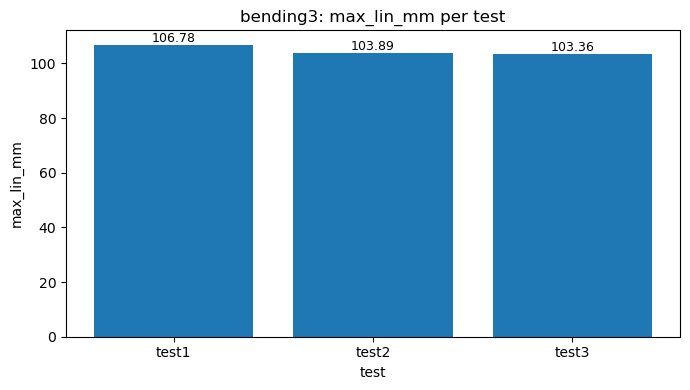

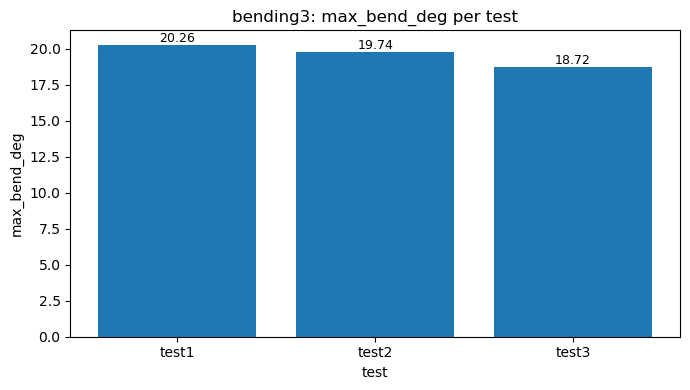

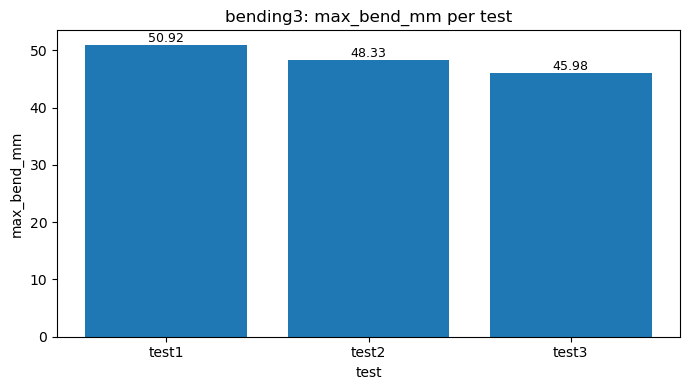

In [22]:
# === Cell 2: Plot all tests of a selected design across selected metrics ===

def _nat_order_tests(test_labels):
    # orders ["test1","test2","test10",...] numerically if possible
    def _key(t):
        num = "".join(ch for ch in str(t) if ch.isdigit())
        return int(num) if num.isdigit() else 0
    return sorted(map(str, test_labels), key=_key)

def plot_design_tests_metrics(data: pd.DataFrame, design: str, metrics: List[str]) -> None:
    sub = data[data["design"] == design].copy()
    if sub.empty:
        print(f"[WARN] No rows for design '{design}'.")
        return

    order = _nat_order_tests(sub["test"].unique())
    sub["test"] = pd.Categorical(sub["test"], categories=order, ordered=True)
    sub = sub.sort_values("test")

    for metric in metrics:
        if metric not in sub.columns:
            print(f"[WARN] Metric '{metric}' not found; skipping.")
            continue

        xs = sub["test"].astype(str).tolist()
        ys = sub[metric].astype(float).tolist()

        plt.figure(figsize=(7, 4))
        plt.bar(xs, ys)
        plt.title(f"{design}: {metric} per test")
        plt.xlabel("test")
        plt.ylabel(metric)
        for x, y in zip(xs, ys):
            plt.text(x, y, f"{y:.2f}", ha="center", va="bottom", fontsize=9)
        plt.tight_layout()
        plt.show()

# --- set designs and metrics; call function ---
selected_design2 = "bending3"
selected_metrics2 = ["max_lin_mm", "max_bend_deg", "max_bend_mm"]
plot_design_tests_metrics(df, design=selected_design2, metrics=selected_metrics2)




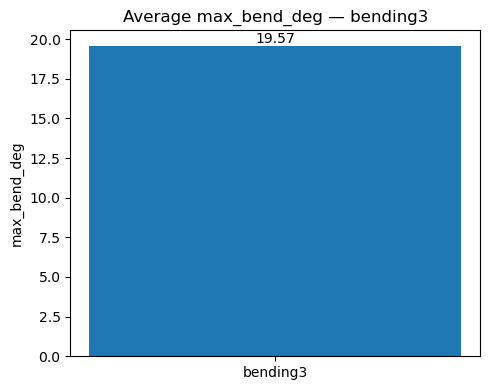

In [23]:
# === Cell 3: Plot the average stats of a selected design and one metric ===

def plot_avg_for_design_metric(data: pd.DataFrame, design: str, metric: str) -> None:
    if metric not in data.columns:
        print(f"[WARN] Metric '{metric}' not found.")
        return
    sub = data[data["design"] == design]
    if sub.empty:
        print(f"[WARN] No rows for design '{design}'.")
        return
    avg_val = float(sub[metric].mean())

    plt.figure(figsize=(5, 4))
    plt.bar([design], [avg_val])
    plt.title(f"Average {metric} — {design}")
    plt.ylabel(metric)
    plt.text(0, avg_val, f"{avg_val:.2f}", ha="center", va="bottom", fontsize=10)
    plt.tight_layout()
    plt.show()

# --- set design and metrics; call function ---
selected_design3 = "bending3"
selected_metric3 = "max_bend_deg"
plot_avg_for_design_metric(df, design=selected_design3, metric=selected_metric3)


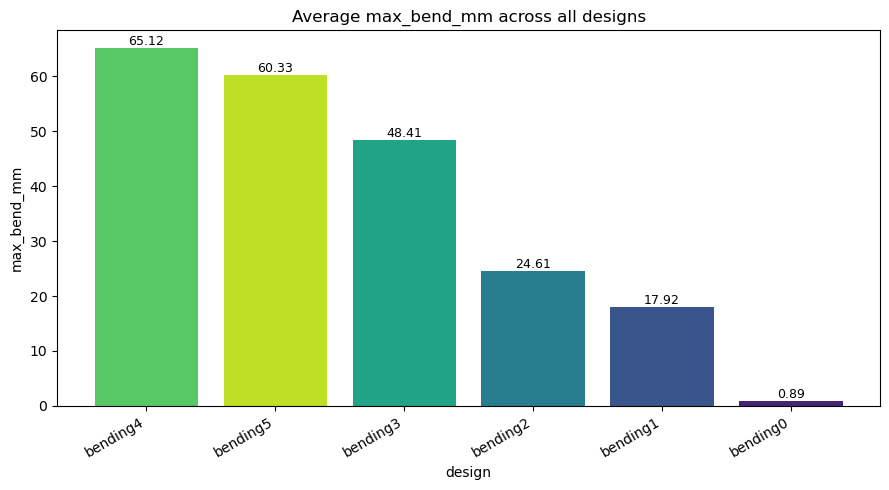

Error: The provided model does not have an 'export' method.


In [26]:
# === Cell 4: Plot average stats of ALL designs for a selected metric ==

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _numeric_suffix(label: str):
    """Return trailing integer in a label (e.g., 'test12' -> 12), or None."""
    m = re.search(r'(\d+)$', str(label))
    return int(m.group(1)) if m else None

def _colors_for_labels(labels, cmap_name="viridis", span=(0.1, 0.9)):
    """
    Map labels to a gradient along a matplotlib colormap.
    Ordering preference:
      1) by trailing numeric suffix if present (e.g., test0, test1, ...)
      2) otherwise alphabetical
    The gradient spans a subset of the colormap (span) for contrast.
    """
    cmap = plt.get_cmap(cmap_name)
    pairs = [(lab, _numeric_suffix(lab)) for lab in labels]
    if any(n is not None for _, n in pairs):
        ordered = sorted(pairs, key=lambda t: (float('inf') if t[1] is None else t[1], str(t[0])))
    else:
        ordered = sorted(pairs, key=lambda t: str(t[0]))

    rank = {lab: i for i, (lab, _) in enumerate(ordered)}
    n = len(labels)
    if n == 1:
        xs = np.array([(span[0] + span[1]) / 2.0])
    else:
        xs = np.linspace(span[0], span[1], n)
    # assign color by rank, return in the same order as input labels
    return [cmap(xs[rank[lab]]) for lab in labels]

def plot_avg_all_designs_metric(data: pd.DataFrame, metric: str, cmap_name: str = "viridis") -> None:
    """
    Bar chart of average <metric> across all designs, with a gradient color theme
    that follows numeric label order (e.g., design0, design1, design2...).
    """
    if metric not in data.columns:
        print(f"[WARN] Metric '{metric}' not found.")
        return

    # Build averages
    designs = data["design"].unique()
    avg_rows = []
    for d in designs:
        sub = data.loc[data["design"] == d, metric].dropna()
        if not sub.empty:
            avg_rows.append({"design": d, metric: sub.mean()})
    if not avg_rows:
        print(f"[WARN] No average stats computed for metric '{metric}'.")
        return

    avg_df = pd.DataFrame(avg_rows).set_index("design").sort_values(metric, ascending=False)

    # Colors based on numeric order of labels (not the sort by value)
    colors = _colors_for_labels(list(avg_df.index), cmap_name=cmap_name)

    # Plot
    plt.figure(figsize=(9, 5))
    x = np.arange(len(avg_df))
    plt.bar(x, avg_df[metric].values, color=colors, edgecolor="none")
    plt.xticks(x, avg_df.index, rotation=30, ha="right")
    plt.title(f"Average {metric} across all designs")
    plt.xlabel("design")
    plt.ylabel(metric)

    # value labels
    for xi, yi in zip(x, avg_df[metric].values):
        plt.text(xi, yi, f"{yi:.2f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()


# --- set metric; call function ---
selected_metric4 = "max_bend_mm"
fig1 = plot_avg_all_designs_metric(df, metric=selected_metric4)
title = f"avg_all_designs_{selected_metric4}"
export.export_plot(fig1, title=title, export_type="png", directory=".", folder="plots", overwrite=False)

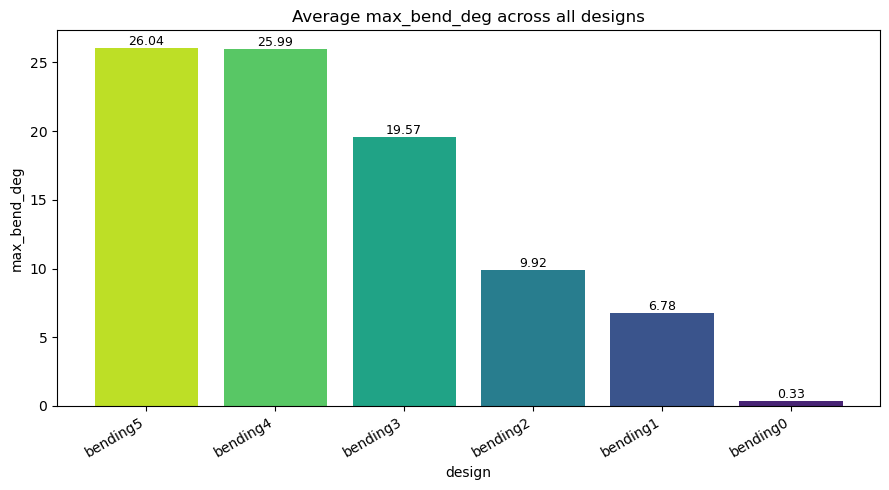

In [25]:
# --- set metric; call function ---
selected_metric4 = "max_bend_deg"
plot_avg_all_designs_metric(df, metric=selected_metric4)